In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [11]:
df = pd.read_csv('../dataset/cleaned_gc=f.csv')

In [ ]:
# Flip the column
df = df.iloc[::-1]

# Reset the index
df = df.reset_index(drop=True)

In [23]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2024-11-05,2740.300049,2740.300049,2743.899902,2740.300049,2743.000000,16
1,2024-11-04,2736.100098,2736.100098,2737.100098,2736.100098,2736.500000,16
2,2024-11-01,2738.600098,2738.600098,2756.000000,2734.199951,2745.500000,109
3,2024-10-31,2738.300049,2738.300049,2787.500000,2733.500000,2787.399902,849
4,2024-10-30,2788.500000,2788.500000,2789.000000,2774.600098,2774.600098,231
...,...,...,...,...,...,...,...
1467,2019-01-08,1283.199951,1283.199951,1283.199951,1278.199951,1280.500000,54
1468,2019-01-07,1286.800049,1286.800049,1286.800049,1286.599976,1286.800049,2
1469,2019-01-04,1282.699951,1282.699951,1294.199951,1275.300049,1294.199951,34
1470,2019-01-03,1291.800049,1291.800049,1292.000000,1286.699951,1286.800049,10


# SPLITTING DATA(7-2-1)

In [34]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9645.029, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9350.910, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=9179.079, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9110.179, Time=0.13 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=9045.837, Time=0.17 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=9034.561, Time=0.23 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=9036.561, Time=0.40 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 2.700 seconds


ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[1895.7184482  1895.00388945 1897.28093244 1898.73761636 1896.55110718
 1894.42541883 1894.02145002 1893.94879542 1893.58762556 1892.69174071
 1891.70774182 1891.05852272 1890.53045321 1889.90364044 1889.18236727
 1888.44904701 1887.77217249 1887.12596308 1886.4596549  1885.77211912
 1885.0840893  1884.40657501 1883.73506045 1883.0600622  1882.38045715
 1881.70078711 1881.02331331 1880.34695333 1879.6699487  1878.99202155]


In [49]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 187.6318828429618
Validation RMSE: 527.1577339669614
Testing MAE: 168.44498002627725
Validation MAE: 525.87608000082
Testing MAPE: 0.10736758596042001
Validation MAPE: 0.398886642623192


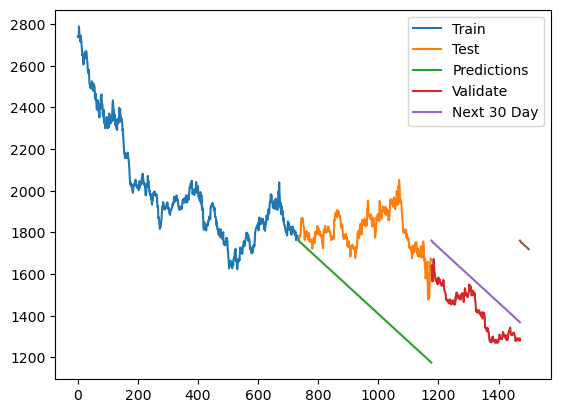

In [73]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1030
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -4511.281
Date:                Thu, 07 Nov 2024   AIC                           9034.561
Time:                        09:14:00   BIC                           9064.173
Sample:                             0   HQIC                          9045.801
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8925      0.031    -28.414      0.000      -0.954      -0.831
ar.L2         -0.7705      0.040    -19.089      0.000      -0.850      -0.691
ar.L3         -0.5404      0.044    -12.380      0.000      -0.626      -0.455
ar.L4         -0.3495      0.039     -9.064      0.000      -0.425      -0.274
ar.L5         -0.1138      0.030     -3.828      0.000      -0.172      -0.056
sigma2       379.1267     12.319     30.775      0.000     354.981     403.272
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               173.11
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.48
Prob(H) (two-sided):                  0.67   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [52]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [54]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7587.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7587.696, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7587.526, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7588.734, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7589.185, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.272 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [56]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [57]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1783.01584893 1781.93172187 1780.8475948  1779.76346773 1778.67934067
 1777.5952136  1776.51108653 1775.42695946 1774.3428324  1773.25870533
 1772.17457826 1771.0904512  1770.00632413 1768.92219706 1767.83807
 1766.75394293 1765.66981586 1764.5856888  1763.50156173 1762.41743466
 1761.3333076  1760.24918053 1759.16505346 1758.08092639 1756.99679933
 1755.91267226 1754.82854519 1753.74441813 1752.66029106 1751.57616399]


In [59]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  193.3586111405274
Testing MAE:  168.34020477192198
Testing MAPE:  0.09646000452830322
Validation RMSE:  382.3081979786062
Validation MAE:  380.39467215157566
Validation MAPE:  0.2884397989431049


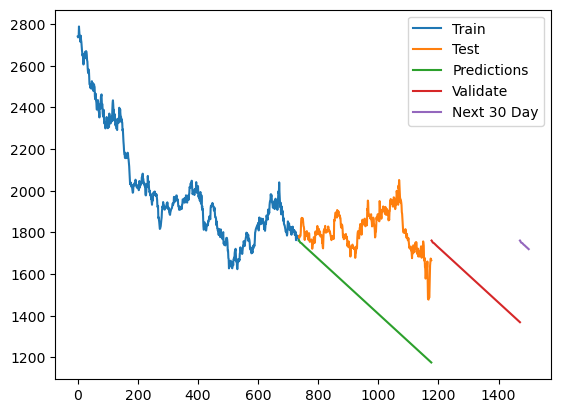

In [75]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [62]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [64]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6342.913, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6347.823, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6346.936, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6346.712, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6349.792, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6349.816, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6347.686, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6344.662, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6344.635, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6348.520, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6344.985, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6346.728, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6344.853, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6344.836, Time=0.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [67]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [68]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1760.78845365 1759.01189677 1756.11144083 1753.21956671 1751.15879706
 1750.0926127  1749.61720608 1749.12690634 1748.18723384 1746.71728319
 1744.93691981 1743.16999949 1741.64595856 1740.40458635 1739.32624434
 1738.23780091 1737.01813393 1735.64781873 1734.19191731 1732.74296576
 1731.36488615 1730.06707822 1728.81418006 1727.55674277 1726.26104221
 1724.92257821 1723.56055979 1722.20140575 1720.8629026  1719.54717636]


In [69]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  383.0028302638576
Testing MAE:  338.3813777449579
Testing MAPE:  0.18625474131361222
Validation RMSE:  150.36504469967957
Validation MAE:  143.3123485701104
Validation MAPE:  0.10182565233708649


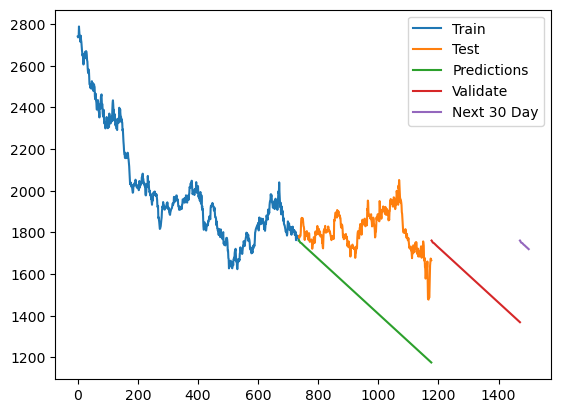

In [74]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# Comparison

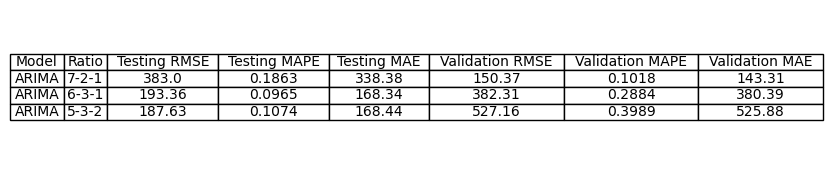

In [77]:
# Define the corrected data for the evaluation table
evaluation_data_corrected = {
    "Model": ["ARIMA", "ARIMA", "ARIMA"],
    "Ratio": ["7-2-1", "6-3-1", "5-3-2"],
    "Testing RMSE": [383.00, 193.36, 187.63],
    "Testing MAPE": [0.1863, 0.0965, 0.1074],
    "Testing MAE": [338.38, 168.34, 168.44],
    "Validation RMSE": [150.37, 382.31, 527.16],
    "Validation MAPE": [0.1018, 0.2884, 0.3989],
    "Validation MAE": [143.31, 380.39, 525.88]
}

# Create a DataFrame from the corrected data
evaluation_df_corrected = pd.DataFrame(evaluation_data_corrected)

# Plot the corrected table using matplotlib
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust size as needed
ax.axis('off')  # Hide the axis

# Render the corrected table
table = ax.table(cellText=evaluation_df_corrected.values, colLabels=evaluation_df_corrected.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(evaluation_df_corrected.columns))))  # Adjust width of each column

# Save the corrected table as an image
corrected_table_image_path = "C:/HK1/PTTK/new/-STAT3013.-P12_Nhom2-/ComparisonModel/ARIMAEvaluation_Model_Table_Corrected.png"
plt.savefig(corrected_table_image_path, bbox_inches='tight', dpi=300)
plt.show()